In [1]:
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import scanpy as sc
import pandas as pd
import os
from PIL import Image
import imagecodecs
import tifffile as tff
from pyometiff import OMETIFFReader
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

import pickle

# Defining functions

## Read nucleus/cell boundary .csv files + cell summary .csv

In [2]:
#sample_dir="20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003370__P3_D__20230808__140759"
#sample_dir="20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003370__P4_D__20230808__140759"

#sample_dir="20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003496__P1_D__20230808__140759"
#sample_dir="20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003496__P2_D__20230808__140759"

def read_boundary_files(data_dir,sample_dir):
    nucleus_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'nucleus_boundaries.csv.gz'))
    cell_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'cell_boundaries.csv.gz'))
    #transcripts=pd.read_csv(os.path.join(data_dir,sample_dir,'transcripts.csv.gz'))    
    #cells=pd.read_csv(os.path.join(data_dir,sample_dir,'cells.csv.gz'))

    return nucleus_bound,cell_bound

## Read __morphology_focus.ome.tiff__ DAPI-fluorescence picture of slide

In [3]:
#sample_dir="20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003370__P4_D__20230808__140759"

def read_ome_tiff(slide_type,data_dir,sample_dir):
    if slide_type=='focus':
        fn=os.path.join(data_dir,sample_dir,'morphology_focus.ome.tif')

    if slide_type=='mip':    
        fn=os.path.join(data_dir,sample_dir,'morphology_mip.ome.tif')

    if slide_type=='z_stack': 
        fn=os.path.join(data_dir,sample_dir,'morphology.ome.tif')
        
    reader = OMETIFFReader(fpath=fn)
    img_array,metadata,xml_metadata=reader.read()

    return img_array,metadata,xml_metadata

## Calculate the pixel coordinates of nuclei/cell boundaries from size coordinates (X,Y, micrometer)
- ### Add unique pixel ID
- ### Add pixel intensity

In [4]:

def convert_um_to_pixels(nucleus_bound,cell_bound,metadata):
    ## Extract pixel width and height
    pixel_width=np.float64(metadata['PhysicalSizeX'])
    pixel_height=np.float64(metadata['PhysicalSizeY'])

    ## Calculate pixel coordinates for nucleus/cell boundaries
    nucleus_bound['vertex_x_pixel']=(nucleus_bound['vertex_x']/pixel_width).apply(lambda x: round(x))
    nucleus_bound['vertex_y_pixel']=(nucleus_bound['vertex_y']/pixel_height).apply(lambda x: round(x))

    cell_bound['vertex_x_pixel']=(cell_bound['vertex_x']/pixel_width).apply(lambda x: round(x))
    cell_bound['vertex_y_pixel']=(cell_bound['vertex_y']/pixel_height).apply(lambda x: round(x))

    ## Add unique ID for each pixel (row_number_coord * len(col_number_of_image) + col_number_coord)
    nucleus_bound['pixel_number']=nucleus_bound['vertex_y_pixel']*img_array.shape[1]+nucleus_bound['vertex_x_pixel'].values
    nucleus_bound['pixel_intensity']=img_array.ravel()[nucleus_bound['pixel_number']]
    nucleus_bound['pixel_intensity']=nucleus_bound['pixel_intensity'].astype(int)

    cell_bound['pixel_number']=cell_bound['vertex_y_pixel']*img_array.shape[1]+cell_bound['vertex_x_pixel'].values
    cell_bound['pixel_intensity']=img_array.ravel()[cell_bound['pixel_number']]
    cell_bound['pixel_intensity']=cell_bound['pixel_intensity'].astype(int)

    return nucleus_bound,cell_bound


## Calculate nucleus pixel metric: median/mean/max/mode of nucleus pixels

In [5]:
def return_polygon_pixel_metric(x,img_array,metric):
    from matplotlib import path
    import statistics as st
    
    ## Extract the vertex points of nucleus polygon + boundaries of 
    polygon_vert=list(zip(x['vertex_x_pixel'],x['vertex_y_pixel']))

    ## Extract rectangle around nucleus -> get coordinates of nucleus polygon and create rectangle
    x_min=int(x['vertex_x_pixel'].min())
    x_max=int(x['vertex_x_pixel'].max())

    y_min=int(x['vertex_y_pixel'].min())
    y_max=int(x['vertex_y_pixel'].max())

    ## Create rectangle around nucleus
    nx,ny=x_max-x_min+1,y_max-y_min+1
    x,y=np.meshgrid(np.arange(nx), np.arange(ny))
    x,y=x.flatten()+x_min, y.flatten()+y_min

    points = np.vstack((x,y)).T

    ## Check if created rectangle's pixels are inside/outside of polygon -> 
    #  mask_: boolean mask; False: pixel outside of nucl. polygon; True: pixel inside of nucl. polygon)
    p=path.Path(polygon_vert)
    mask=p.contains_points(points)
    mask_=mask.reshape(ny,nx)

    ## Extract the pixel numbers of the pixels from inside the polygon 
    #  Subset original image to rectangle around nucleus (saves memory)
    sub_img_array=img_array[y_min:y_min+ny,x_min:x_min+nx]

    ## Calculate metric of nucleus pixels (rectangle masked with boolean mask)

    def return_indentity(x):
        return x

    metric_dict={'median':np.median,'mean':np.mean,'max':np.max,'mode':st.mode,'raw_vals':return_indentity}
    metric_func=metric_dict[metric]
    nucleus_polygon_metric=metric_func(sub_img_array[mask_].flatten())



    ## Plotting functions to showcase the pixels of the polygon for one nucleus
    #  For this, run the following code outside of ths function:

    #  cell_id='aaaejiml-1'
    #  nucleus_bound[nucleus_bound['cell_id']==cell_id].groupby('cell_id').apply(return_polygon_pixels,img_array=img_array)

    '''
    ## Plot the nuclues boolean mask 
    fig,ax=plt.subplots(1,4,figsize=(10,13))
    ax[0].imshow(mask_,origin='upper')

    ## Plot the polygon with GeoPandas dataframe for given cell
    nucleus_polygons.loc[nucleus_polygons.index.isin(['aaaejiml-1']),:].plot(ax=ax[1],column='real_cell',cmap=reversed_map,legend=True,alpha=0.3)
    #nucleus_polygons.loc[nucleus_polygons.index.isin(['aaakgmde-1']),:].plot(ax=ax[1],column='real_cell',cmap=reversed_map,legend=True,alpha=0.3)
    ax[1].invert_yaxis()

    ## Show raw nucleus data taken from oiriginal image
    #  Subset original slide image to a rectangle around the nucleus 
    sub_img_array=img_array[y_min:y_min+ny,x_min:x_min+nx]
    img=ax[2].imshow(sub_img_array,origin='upper')

    ## Show nucleus masked with polygon + DAPI intensities inside of polygon
    sub_img_array[~mask_]=0
    img2=ax[3].imshow(sub_img_array,origin='upper')
    plt.colorbar(img2, ax=ax[3])
    plt.show()

    '''
    return nucleus_polygon_metric



# Extract nuclei pixel information for each sample

In [44]:
data_dir="/Volumes/T7/Plaque_Xenium_data"
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"

## Drop scratch folders that start with "._"
panel_dir=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir.sort()
print(panel_dir)

for panel in panel_dir[0:1]:
    panel_dir=os.path.join(data_dir,panel)
 
    ## Loop over all samples in a batch
    for sample_name in os.listdir(panel_dir)[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)
        #print(sample_name)
        if os.path.isdir(sample_dir): #and 'P3_D' in sample_dir:
            sample_dict={}
            print(sample_dir)
            
            
            ## Load nucleus/cell boundary files (outputs of 10x segmentation algorithm Baysor performed on DAPI stained slides)
            nucleus_bound,cell_bound=read_boundary_files(data_dir,sample_dir)
            print('Boundary files loaded')

            ## Load DAPI fluorescent-stained slide image
            # Select one slide_type ('mip'/'focus'/z_stack') file to load and 
            slide_type='mip'
            img_array,metadata,xml_metadata=read_ome_tiff(slide_type,data_dir,sample_dir)
            print('Slide loaded')

            ## Convert coordinates of nucleus/cell boundary polygon vertices (micrometer->pixels) + add intensity of polygon vertex pixels
            nucleus_bound,cell_bound=convert_um_to_pixels(nucleus_bound,cell_bound,metadata)
            
            ## Extract pixels of nucleus polygons (identified by 10x default cell segmenter) and return a dataframe with some metrics of these pixel 
            #  intensities
            metric_df_list=[]
            metric_list=['median','mean','max','mode','raw_vals']
            for metric in metric_list:
                temp_df=nucleus_bound.groupby('cell_id').apply(return_polygon_pixel_metric,img_array=img_array,metric=metric)
                metric_df_list.append(temp_df)                
            del img_array               
            nucleus_polygon_pixel_metrics=pd.concat(metric_df_list,axis=1)
            nucleus_polygon_pixel_metrics.columns=metric_list
            print('Nuclear polygon metrics calculated')

            
            ## Save the processed data as a dictionary
            sample_dict['nucleus_bound']=nucleus_bound
            sample_dict['cell_bound']=cell_bound
            sample_dict['nucleus_polygon_pixel_metrics']=nucleus_polygon_pixel_metrics
            
            proc_dir='../xenium_data/processed_data/true_cell_filtering/10x'
            
            if not os.path.isdir(proc_dir):
                os.makedirs(proc_dir)
                print(f'Created directory: {proc_dir}')

            fn='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])+'.pickle'
            fpath=os.path.join(proc_dir,fn)
            pickle.dump(sample_dict, open(fpath, "wb"))
            print(f'{fn} saved as pickle\n')
            
            

['20230808__140639__2311-01_Sachs_Panel1', '20230817__135824__2311_Sachs_Panel2']
/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003370__P3_H__20230808__140759
Boundary files loaded
Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
Slide loaded
Nuclear polygon metrics calculated
Panel1_P3_H.pickle saved as pickle

/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003496__P2_D__20230808__140759
Boundary files loaded
Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
Slide loaded
Nuclear polygon metrics calculated
Panel1_P2_D.pickle saved as pickle

/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/20230808__140639__2311-01_Sachs_Panel1/output-XETG00050__0003370__P3_D__20230808__140759
Boundary files loaded
Key not found: 

## Distribution of nucleus metric + setting the nuclei metric threshold

['20230808__140639__2311-01_Sachs_Panel1', '20230817__135824__2311_Sachs_Panel2']


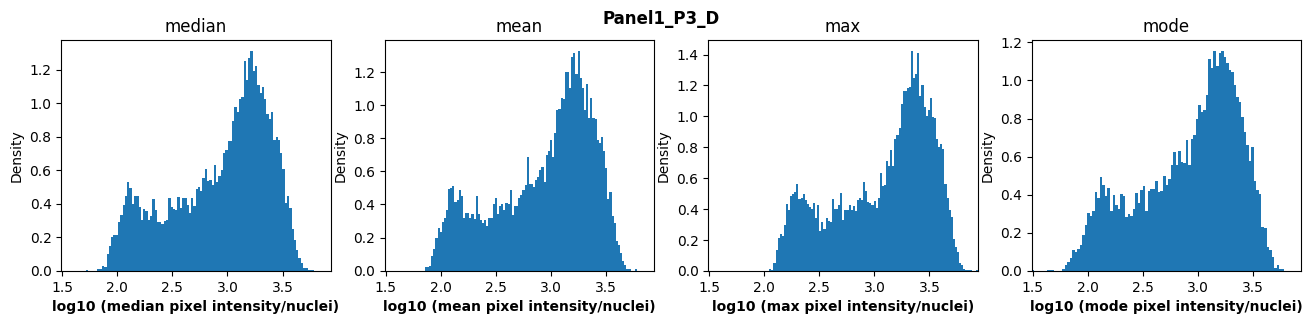

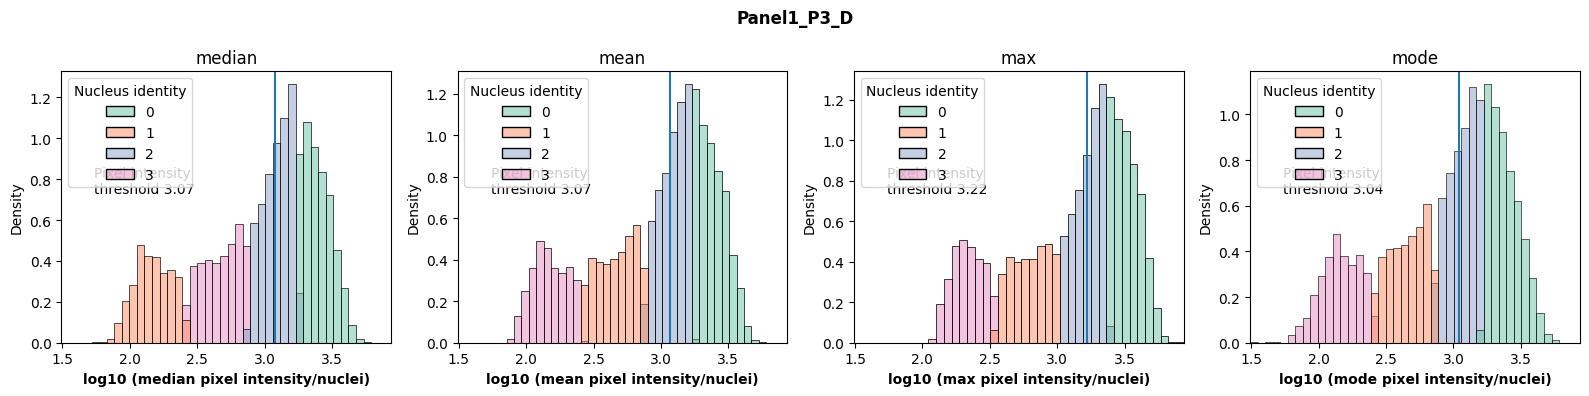

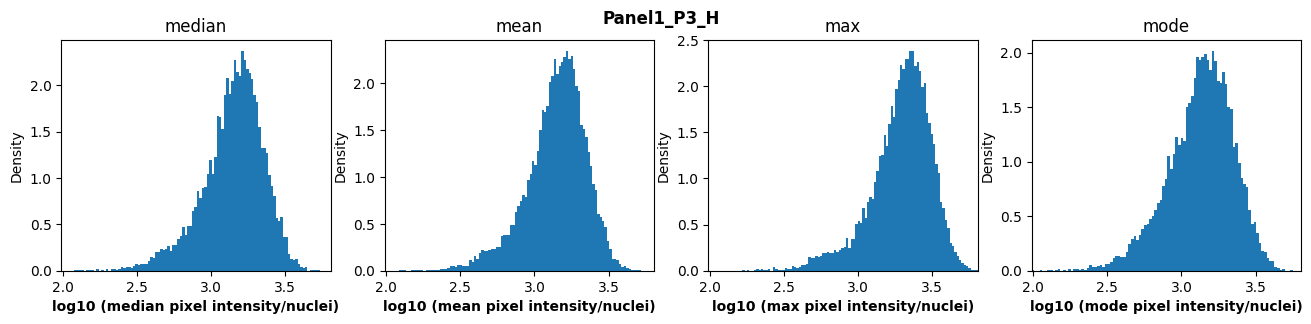

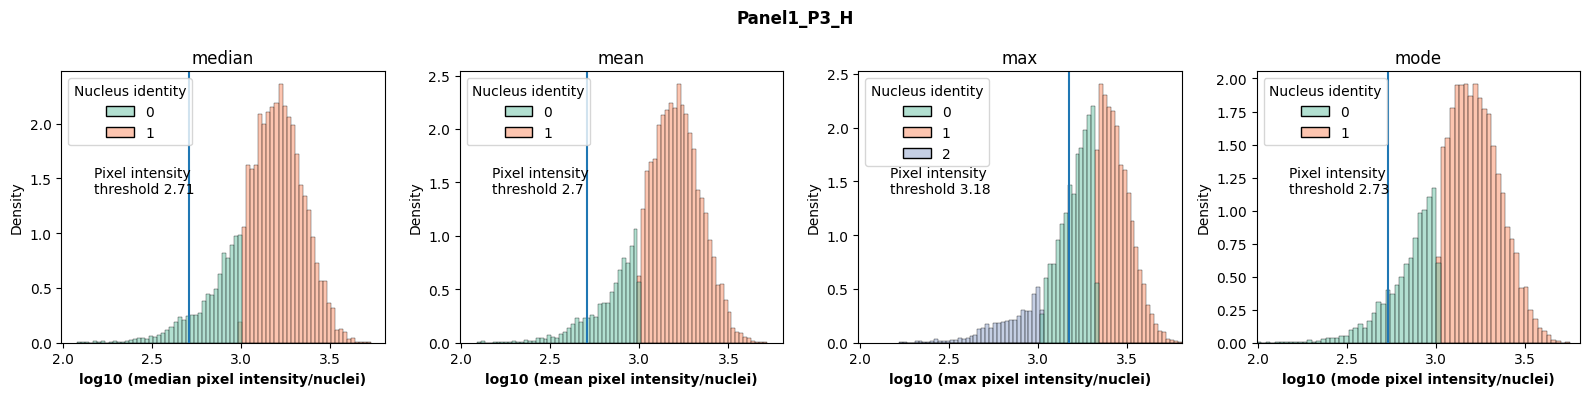

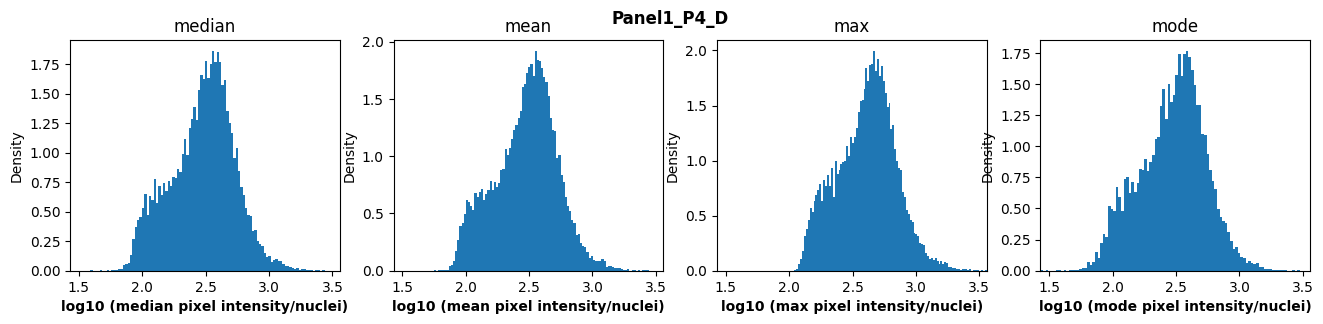

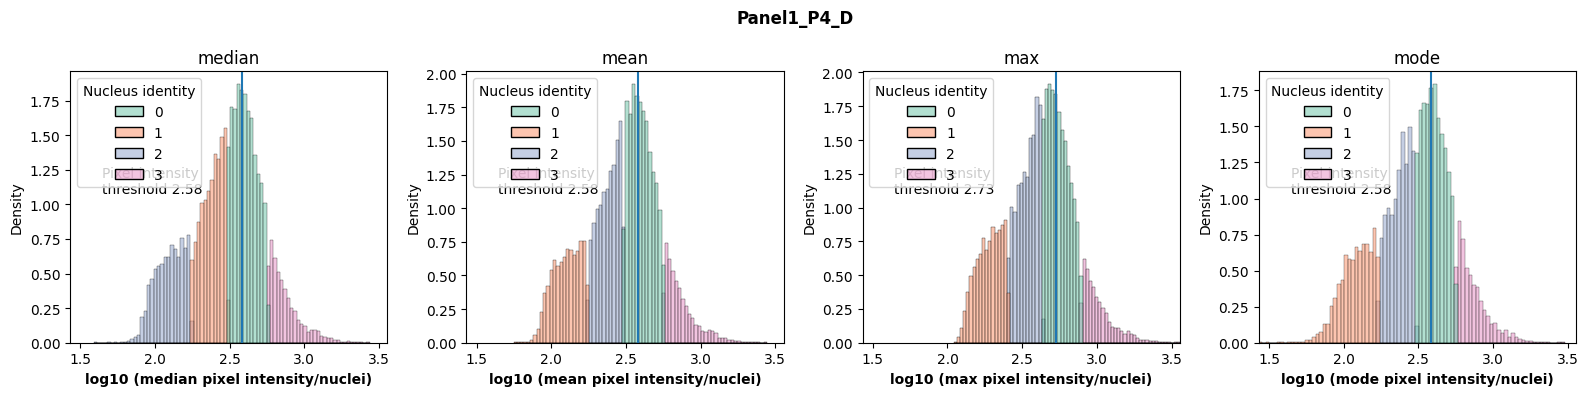

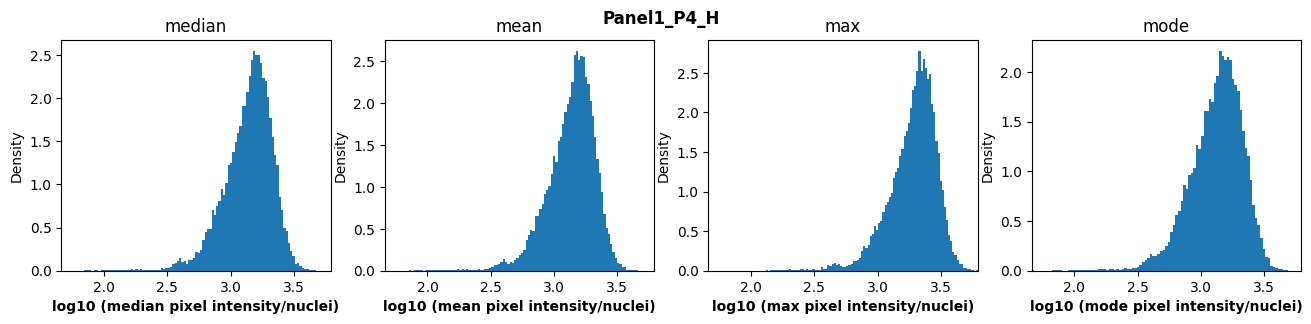

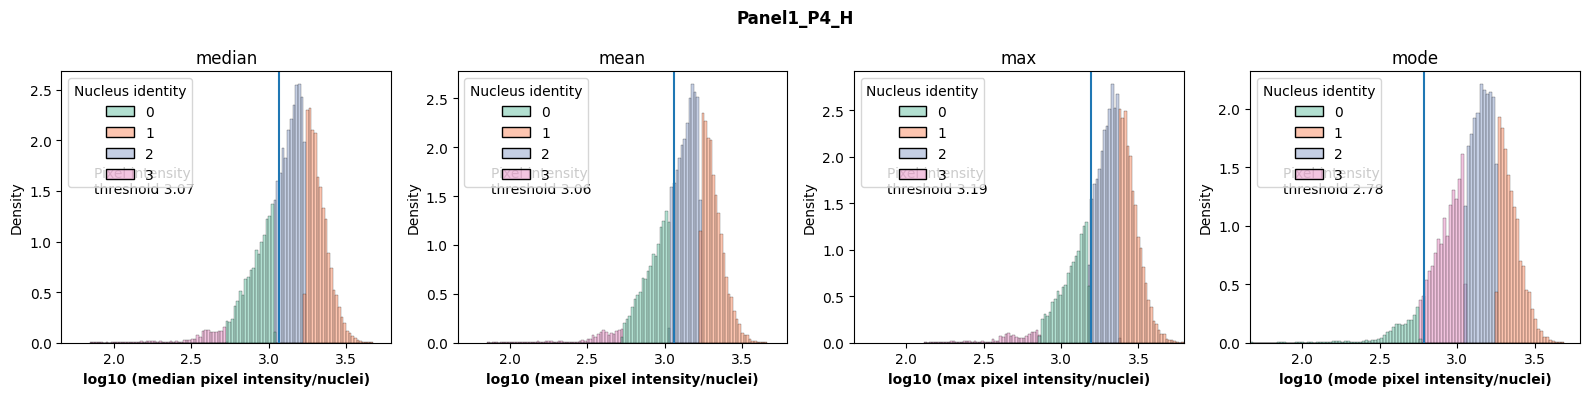

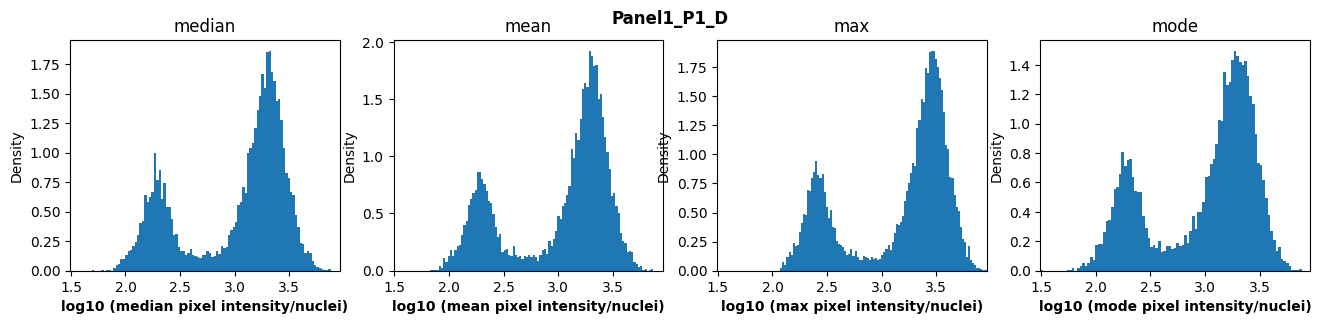

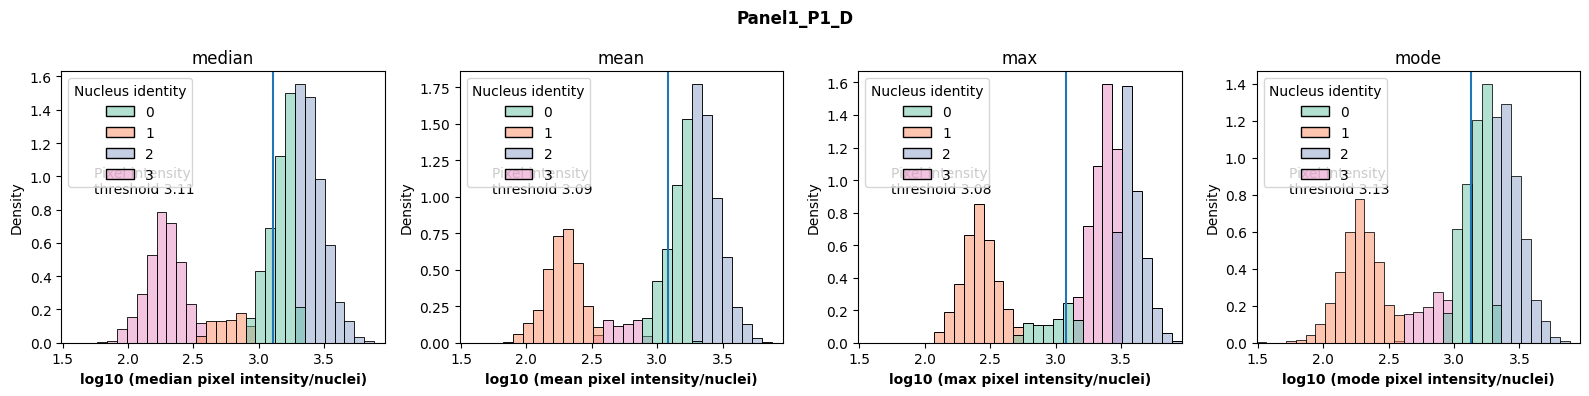

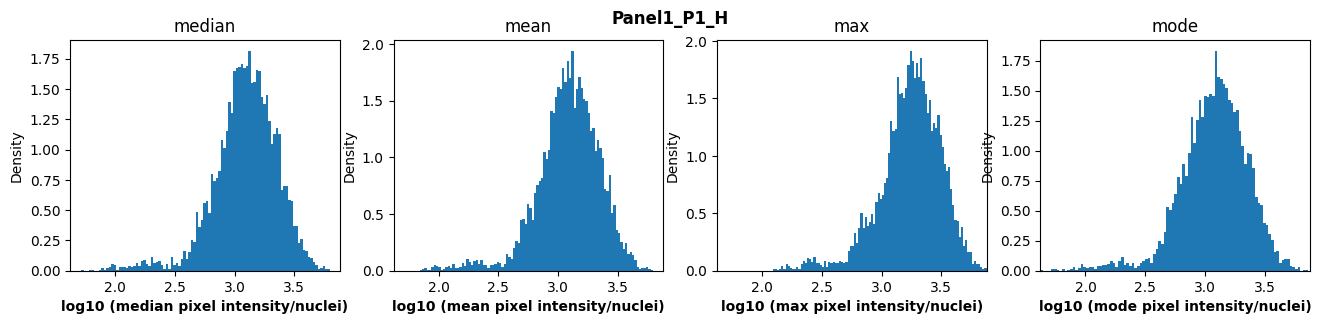

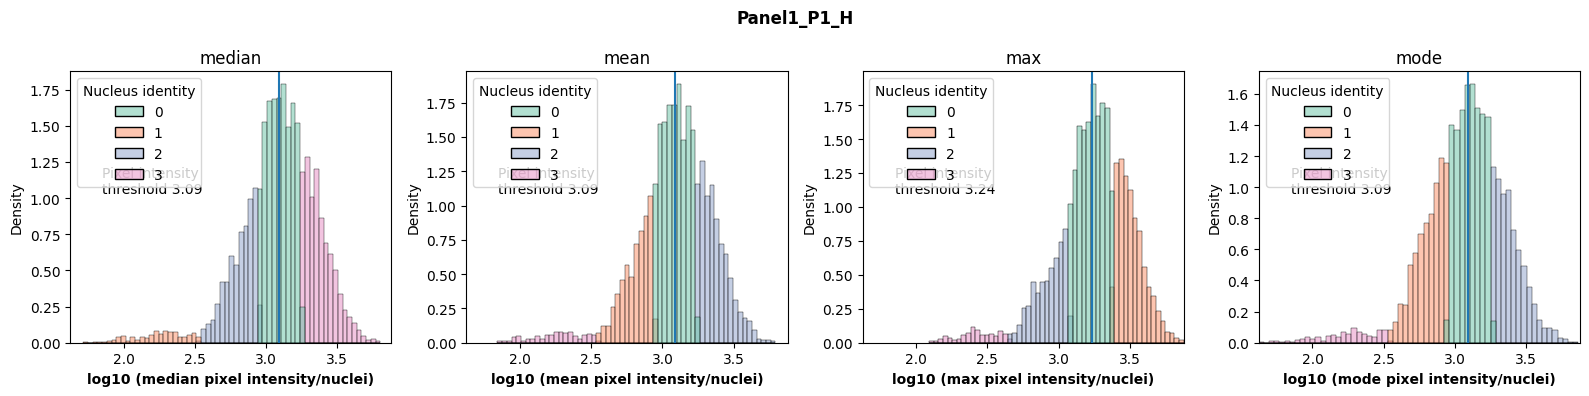

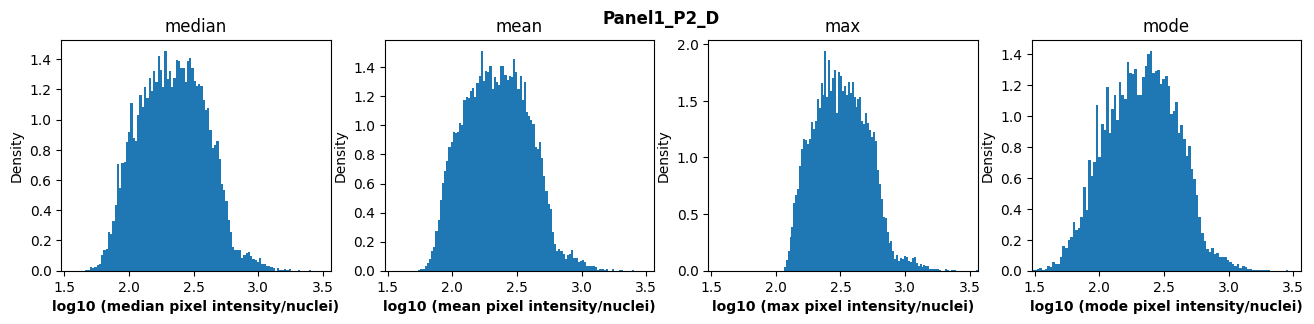

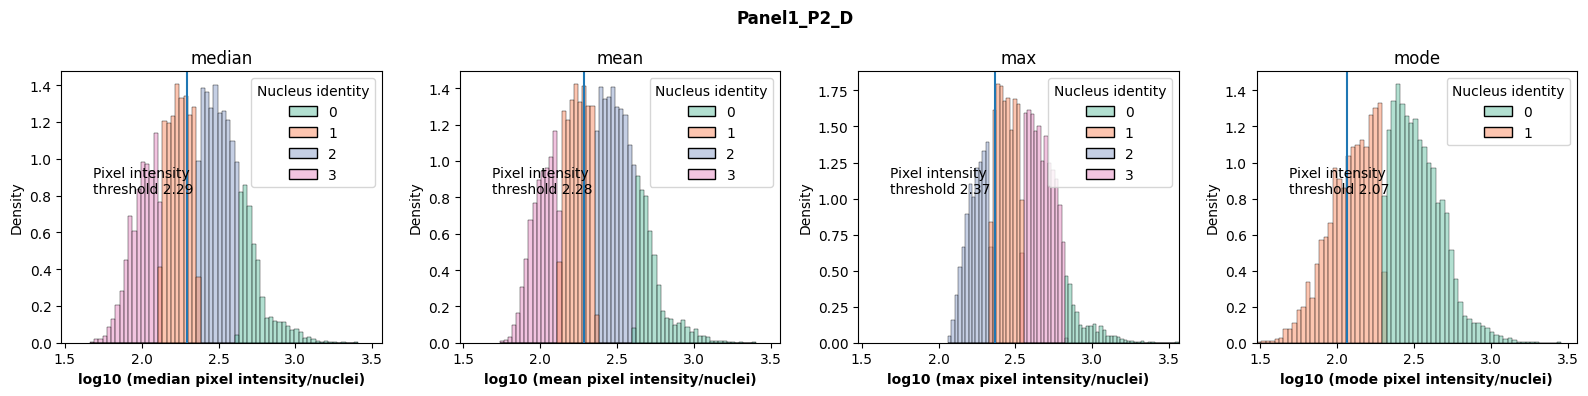

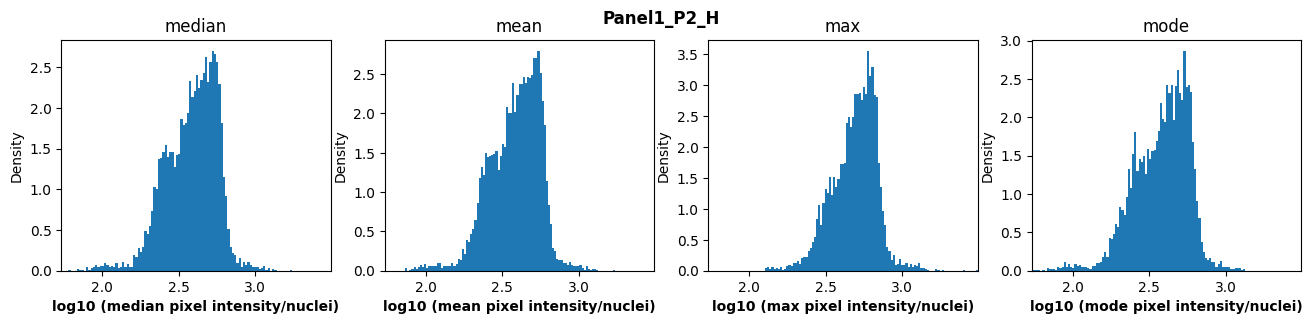

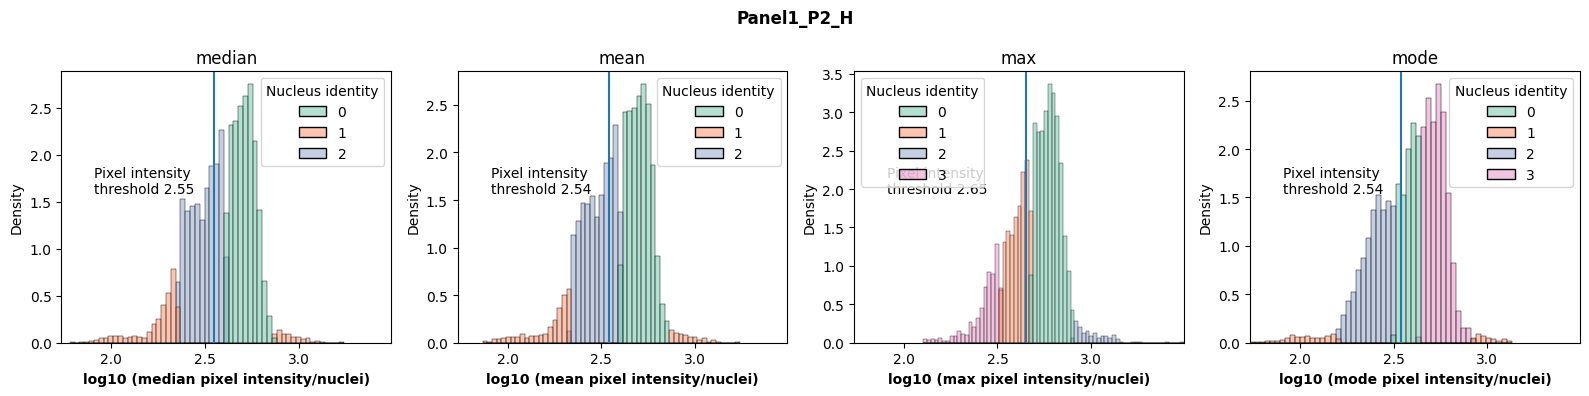

In [56]:
import math
metric_list=['median','mean','max','mode']

data_dir="/Volumes/T7/Plaque_Xenium_data"
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"
proc_dir='../xenium_data/processed_data/true_cell_filtering/10x'

## Drop scratch folders that start with "._"
panel_dir=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir.sort()
print(panel_dir)

for panel in panel_dir[0:1]:
    panel_dir=os.path.join(data_dir,panel)
    sample_name_list=os.listdir(panel_dir)
    sample_name_list.sort()

    ## Loop over all samples in a batch
    for sample_name in sample_name_list[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)
        #print(sample_name)
        if os.path.isdir(sample_dir):# and 'P3_D' in sample_dir:

            fn='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])+'.pickle'
            fpath=os.path.join(proc_dir,fn)
            sample_dict=pickle.load(open(fpath, "rb"))

            #sample_dict['nucleus_bound']=nucleus_bound
            #sample_dict['cell_bound']=cell_bound
            nucleus_polygon_pixel_metrics=sample_dict['nucleus_polygon_pixel_metrics']

            nrows=1
            ncols=math.ceil(len(metric_list)/nrows)

            fig1=plt.figure(figsize=(ncols*4,nrows*3))
            fig2=plt.figure(figsize=(ncols*4,nrows*4))

            xmin=np.log10(nucleus_polygon_pixel_metrics[metric_list].values).min()
            xmax=np.log10(nucleus_polygon_pixel_metrics[metric_list].values).max()

            for n,metric in enumerate(metric_list):

                ax1=fig1.add_subplot(nrows,ncols,n+1)
                metric_df=np.log10(nucleus_polygon_pixel_metrics[metric].replace(0,1))
                
                ## PLot distribution of np.log10(nucleus metric)
                ax1.hist(metric_df,bins=100,density=True);
                ax1.set_title(metric)
                ax1.set_xlabel(f'log10 ({metric} pixel intensity/nuclei)',fontweight='bold')
                ax1.set_ylabel('Density')
                ax1.set_xlim(xmin,xmax)
                fig1.suptitle(fn.split('.pickle')[0],fontweight='bold')

                
                #### SET THRESHOLD OF NUCLEUS METRIC IN ORDER TO SEPARATE CORRECT/FALSELY LABELED NUCLEI BY BAYSOR (10X CELL SEGMENTATION MODEL)
                ## FIT MIXED GAUSSIAN MODELS TO THE NUCLEUS METRIC DISTRIBUTION -> DISTRIBUTION OF NUCLEI WITH HIGHEST MEAN ARE REAL CELLS
                X=metric_df.values.reshape(-1,1)

                # Find the optimal number of components using the Akaike information criterion (AIC) or Bayesian information criterion (BIC)
                n_components = np.arange(1, 5)
                models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]
                bic = [model.bic(X) for model in models]
                optimal_n_components = n_components[np.argmin(bic)]

                # Fit GMM with the optimal number of components
                gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=0)
                #gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
                gmm.fit(X)
                labels = gmm.predict(X)

                # Extract mean and variance of distribution with highest mean (==real nuclei population)
                max_mean=np.max(gmm.means_)
                max_var=gmm.covariances_[np.where(np.max(gmm.means_))]

                ## SET THRESHOLD BASED ON THE QUANTILE OF THE GAUSSIAN DISTRIBUTION OF REAL NUCLEI
                # Set quantile and then extract the threshold of a Gaussian scaled with the real nuclei distr. mean + variance
                quant=0.01
                int_thr_exponent=norm.ppf(quant, loc=max_mean, scale=max_var**0.5).flatten()[0]


                # Plot the data and the fitted Gaussians
                plot_df=pd.DataFrame({'values':X.reshape(-1,),'Nucleus identity':labels})
                #plot_df['Nucleus identity']=plot_df['Nucleus identity'].replace({0:'True',1:'False'},regex=True)
                
                ax2=fig2.add_subplot(nrows,ncols,n+1)
                
                sns.histplot(data=plot_df,x='values',hue='Nucleus identity',ax=ax2,stat='density',palette='Set2')
                ax2.axvline(int_thr_exponent)
                ax2.set_title(metric)
                ax2.set_xlabel(f'log10 ({metric} pixel intensity/nuclei)',fontweight='bold')
                ax2.set_xlim(xmin,xmax)
                ax2.text(xmin+(xmax-xmin)*0.1,ax2.get_ylim()[1]*0.55,f'Pixel intensity\nthreshold {round(int_thr_exponent,2)}')
                fig2.suptitle(fn.split('.pickle')[0],fontweight='bold')

                #print(f'Pixel intesity threshold: {int_thr_exponent}')
                
            plt.tight_layout()    

## Plot cells with true/false labels

Cell identity
True cell     16453
False cell     4084
Name: count, dtype: int64


/tmp/ipykernel_186965/3176670976.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('summer')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_186965/3176670976.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('Greys')


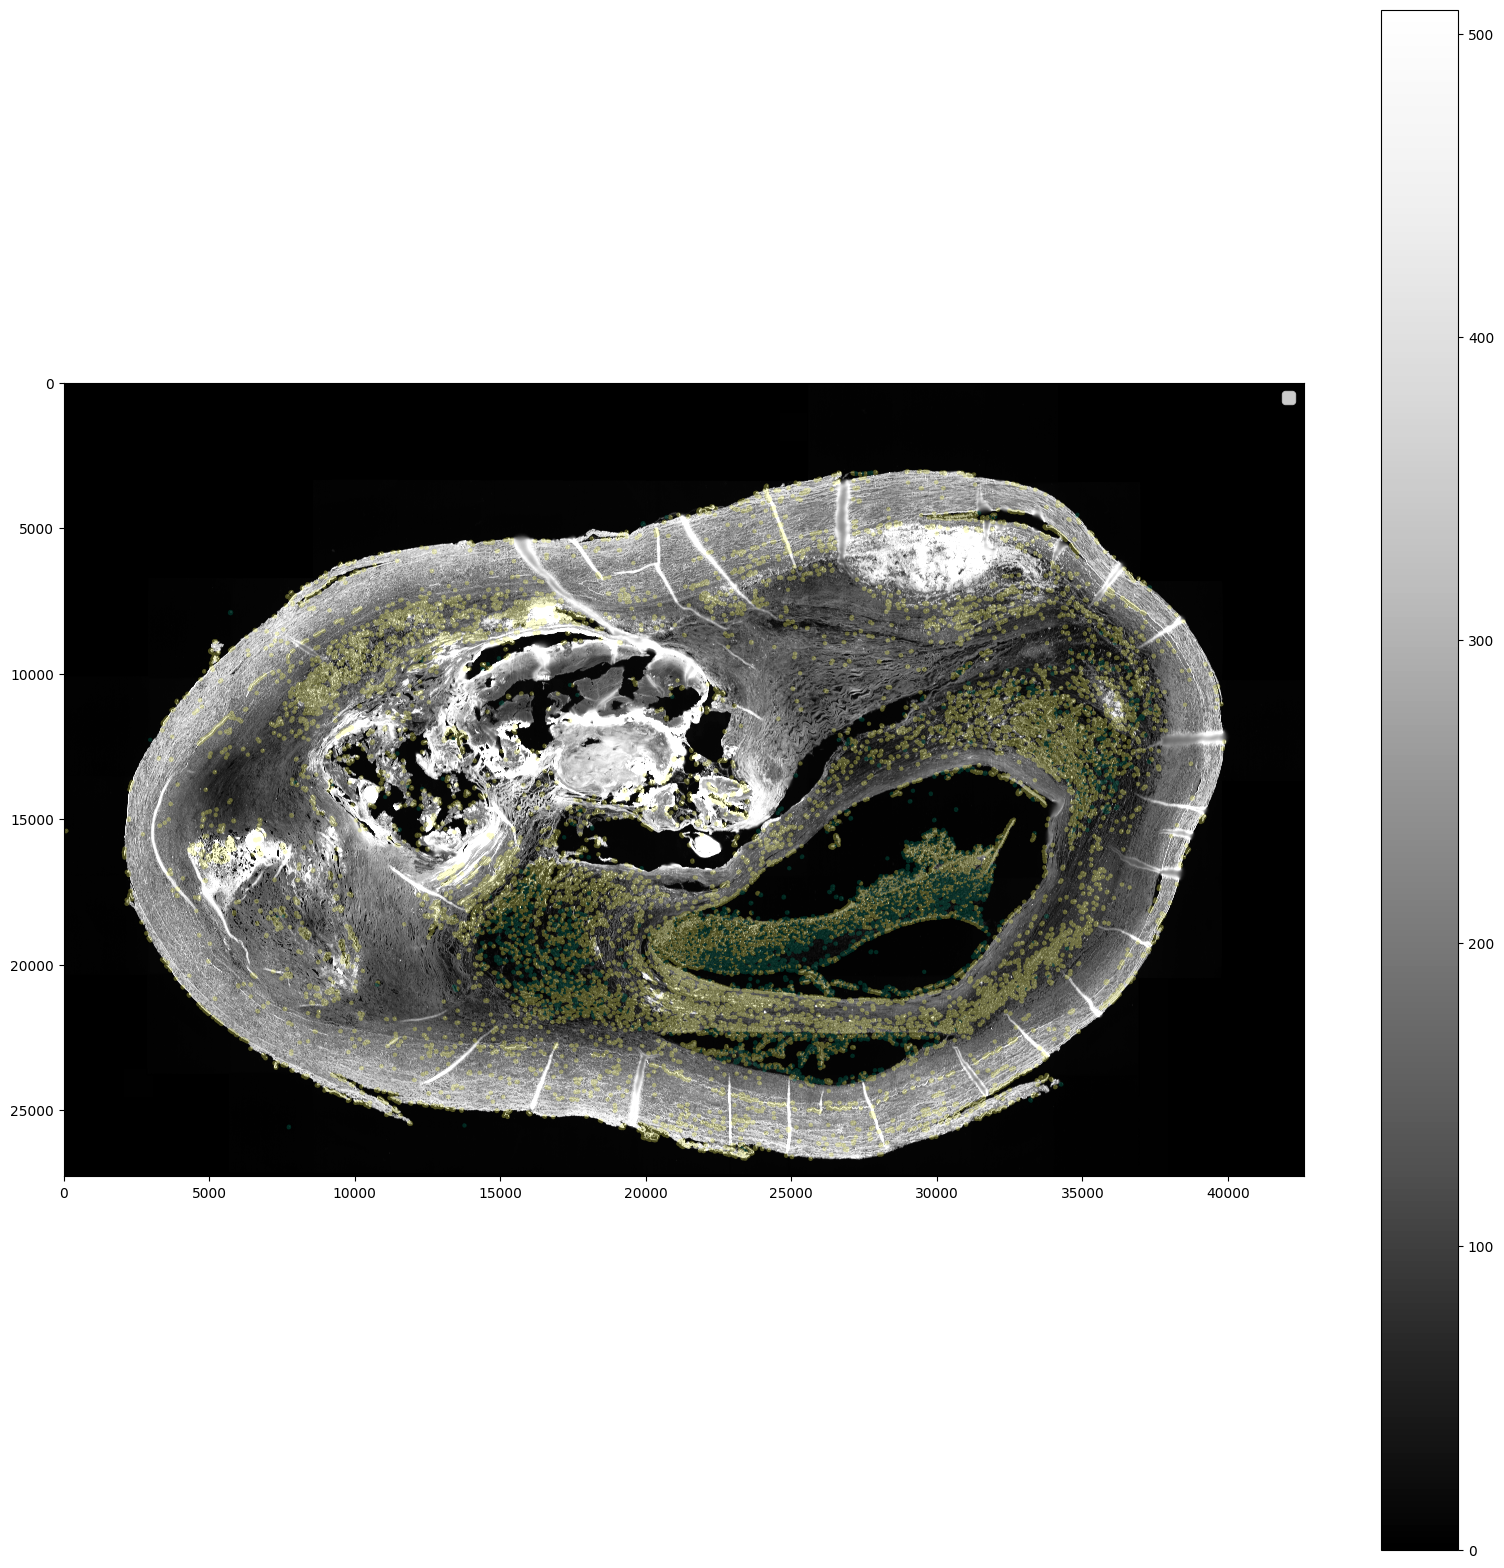

In [8]:
## Set pixel intensity threshold 
int_thr=10**int_thr_exponent


'''
DEPRECATED
## Add new columns to indicate whether the nucleus pixel is above/below threshold
nucleus_bound['pixel_below_thr']=False
nucleus_bound.loc[nucleus_bound['pixel_intensity']<int_thr,'pixel_below_thr']=True
#false_nuclei=nucleus_bound.groupby('cell_id').apply(lambda x: (x['pixel_below_thr'].all()))

#false_nuclei_pixels=nucleus_bound[nucleus_bound['cell_id'].isin(false_nuclei[false_nuclei].index)]['pixel_number'].values
#true_nuclei_pixels=nucleus_bound[nucleus_bound['cell_id'].isin(false_nuclei[~false_nuclei].index)]['pixel_number'].values

#alse_cell_pixels=cell_bound[cell_bound['cell_id'].isin(false_nuclei[false_nuclei].index)]['pixel_number'].values
#true_cell_pixels=cell_bound[cell_bound['cell_id'].isin(false_nuclei[~false_nuclei].index)]['pixel_number'].values
'''

## Extract false nuclei that are below pixel intensity threshold
false_nuclei=nucleus_polygon_pixel_metrics<int_thr


### CREATE GEOPANDAS DATAFRAMES OF FOR PLOTTING TRUE/FALSE NUCLEI
##  Extract pixel coordinates of nuclei polygons 
nucleus_poly_coordinates=nucleus_bound.groupby('cell_id').apply(lambda x: Polygon(zip(x['vertex_x_pixel'],x['vertex_y_pixel'])))
cell_poly_coordinates=cell_bound.groupby('cell_id').apply(lambda x: Polygon(zip(x['vertex_x_pixel'],x['vertex_y_pixel'])))

## Create GeoPandas dataframes containing pixel coordinates of nuclei polygons 
nucleus_polygons=gpd.GeoDataFrame(index=nucleus_poly_coordinates.index,geometry=nucleus_poly_coordinates.values)
cell_polygons=gpd.GeoDataFrame(index=cell_poly_coordinates.index,geometry=cell_poly_coordinates.values)

## Add column indicating if cell is a true/false cell
cell_polygons['Cell identity']='True cell'
cell_polygons.loc[cell_polygons.index.isin(false_nuclei[false_nuclei].index),'Cell identity']='False cell'

nucleus_polygons['Cell identity']='True cell'
nucleus_polygons.loc[nucleus_polygons.index.isin(false_nuclei[false_nuclei].index),'Cell identity']='False cell'


print(nucleus_polygons['Cell identity'].value_counts())


## Plot cells with GeoPandas data indicating Cell identity (true/false) with colors overlaying
fig,ax=plt.subplots(1,1,figsize=(20,20))
orig_map=plt.cm.get_cmap('summer') 
reversed_map = orig_map#.reversed() 
cell_polygons.plot(ax=ax,column='Cell identity',cmap=reversed_map,legend=True,alpha=0.3)
ax.legend(fontsize=12,title_fontsize=30)
#ax.set_facecolor('black')
ax.invert_yaxis()


## Plot original slide -> contrasted to the range of 0-0.98 quantile of pixel intesities 
#  -> whole slide appears brighter, as extreme intensive pixels get capped at 0.98 quantile 
orig_map=plt.cm.get_cmap('Greys') 
reversed_map = orig_map.reversed() 
img=ax.imshow((img_array),cmap=reversed_map,vmin=0, vmax=np.quantile(img_array,0.98))
plt.colorbar(img, ax=ax)
plt.show()



In [ ]:
#adata = sc.read_10x_h5(filename=os.path.join(data_dir,sample_dir,'cell_feature_matrix.h5'))

# Supplementary plots

## Plot full image

In [ ]:
img_array_=np.copy(img_array)
#img_array_[img_array_==0]=1

fig,ax=plt.subplots(1,1,figsize=(20,20))
orig_map=plt.cm.get_cmap('Greys') 
reversed_map = orig_map.reversed() 
img=ax.imshow((img_array_),cmap=reversed_map)
plt.colorbar(img, ax=ax)
plt.show()

## squidpy segmentation demo

In [ ]:
sub_img_array=img_array[round(1350/pixel_width):round(1680/pixel_width),round(2920/pixel_width):round(3250/pixel_width)]
a=sq.im.ImageContainer(img_array)
#a['image'].data
sq.im.process(a, layer='image')
sq.im.segment(img=a, layer='image', method="watershed", thresh=None, geq=True)

fig, axes = plt.subplots(1, 2,figsize=(20,15))
a.show('segmented_watershed',ax=axes[1])
a.show('image',ax=axes[0])

## Plot one nucleus + polygon vertices of nucleus and cell

/tmp/ipykernel_33891/3806700371.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('RdYlBu')


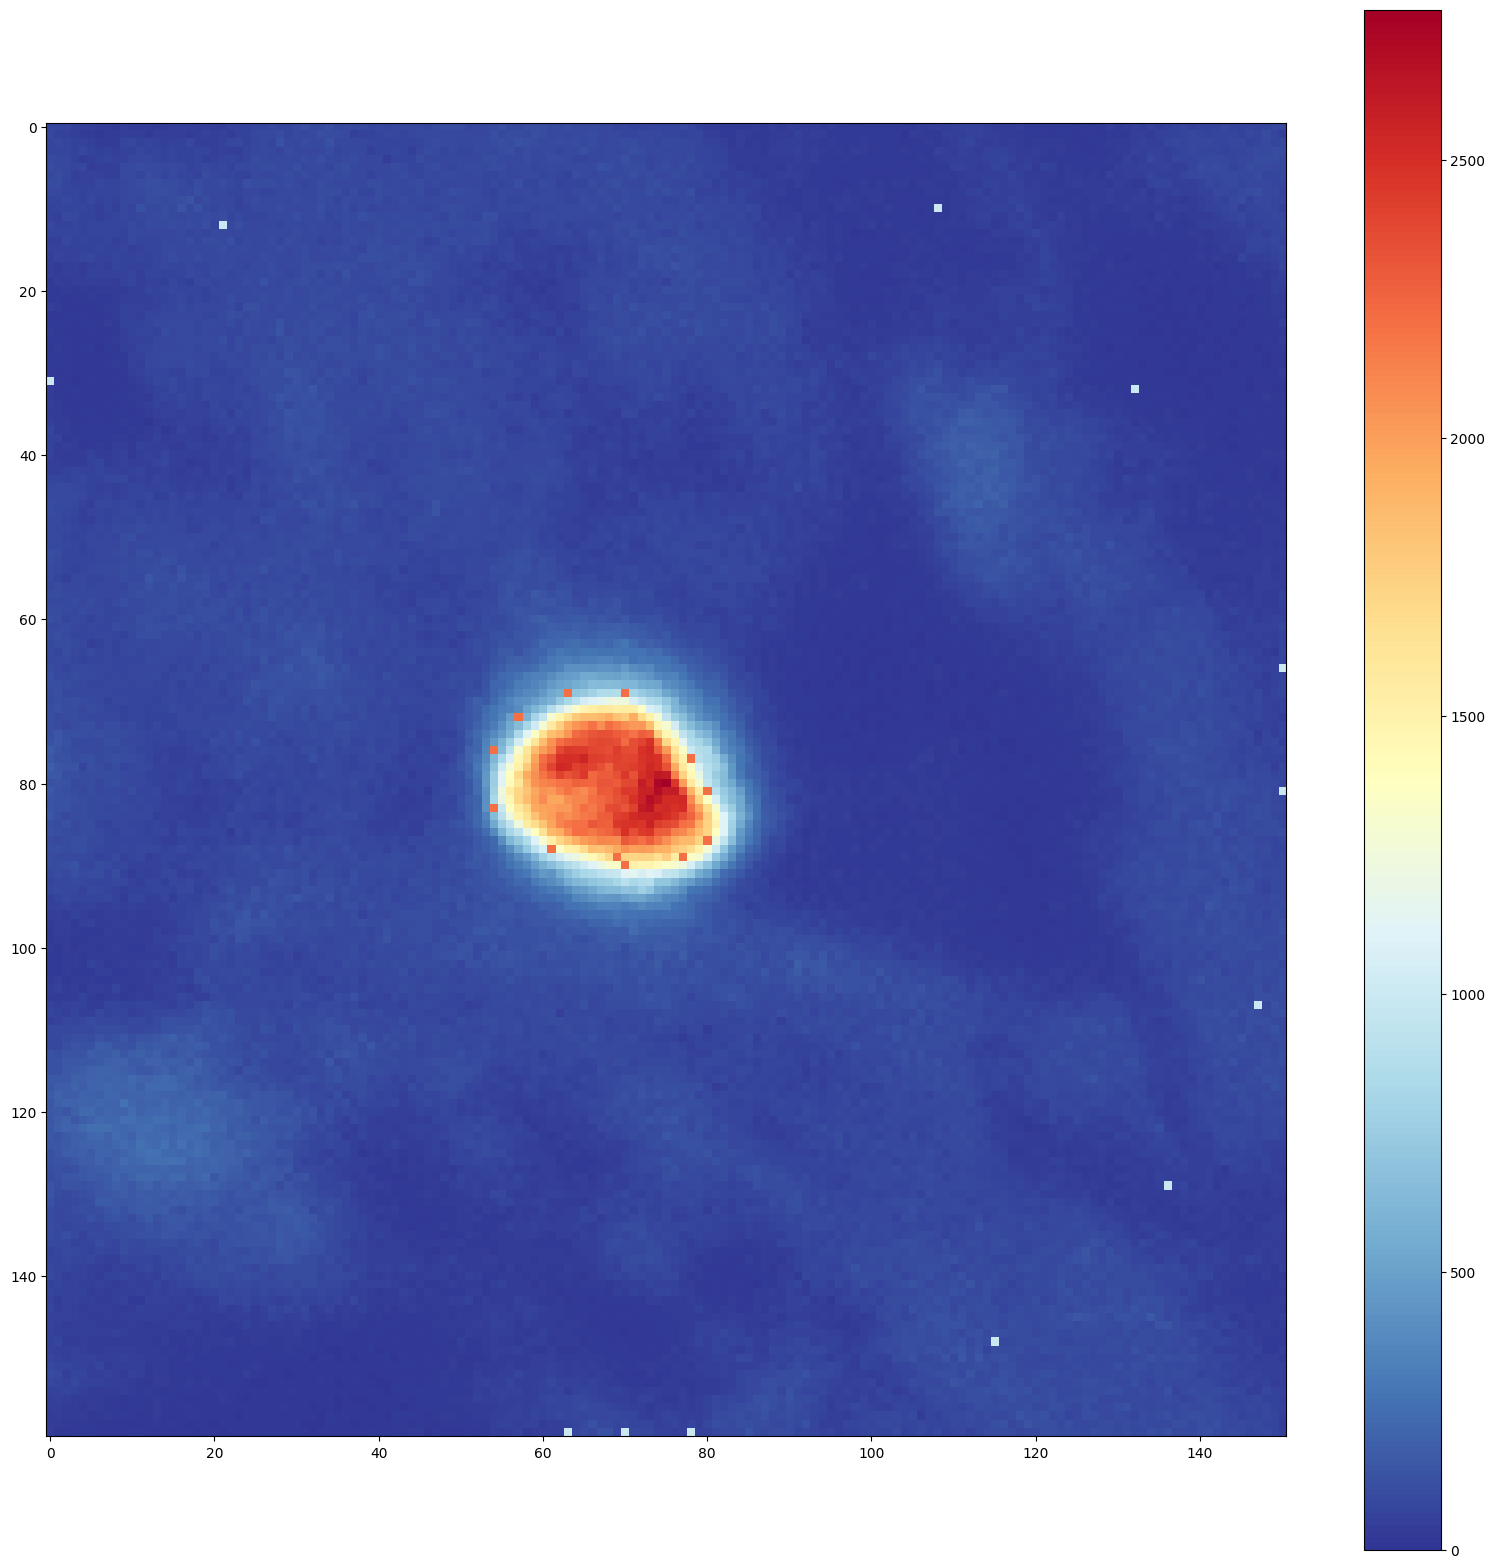

In [99]:
cell_id='gdapanmi-1'
cell_bound[cell_bound['cell_id']==cell_id][['vertex_x_pixel','vertex_y_pixel']]
xmin=cell_bound[cell_bound['cell_id']==cell_id]['vertex_x_pixel'].min()
xmax=cell_bound[cell_bound['cell_id']==cell_id]['vertex_x_pixel'].max()
ymin=cell_bound[cell_bound['cell_id']==cell_id]['vertex_y_pixel'].min()
ymax=cell_bound[cell_bound['cell_id']==cell_id]['vertex_y_pixel'].max()

xmin_=nucleus_bound[nucleus_bound['cell_id']==cell_id]['vertex_x_pixel'].min()
xmax_=nucleus_bound[nucleus_bound['cell_id']==cell_id]['vertex_x_pixel'].max()
ymin_=nucleus_bound[nucleus_bound['cell_id']==cell_id]['vertex_y_pixel'].min()
ymax_=nucleus_bound[nucleus_bound['cell_id']==cell_id]['vertex_y_pixel'].max()

sub_arr=img_array[ymin:ymax,xmin:xmax].copy()

sub_arr[cell_bound[cell_bound['cell_id']==cell_id]['vertex_y_pixel'].values-ymin-1,cell_bound[cell_bound['cell_id']==cell_id]['vertex_x_pixel'].values-xmin-1]=1000
sub_arr[nucleus_bound[nucleus_bound['cell_id']==cell_id]['vertex_y_pixel'].values-ymin-1,nucleus_bound[nucleus_bound['cell_id']==cell_id]['vertex_x_pixel'].values-xmin-1]=2200

fig,ax=plt.subplots(1,1,figsize=(20,20))
orig_map=plt.cm.get_cmap('RdYlBu') 
reversed_map = orig_map.reversed() 
img=ax.imshow(sub_arr,cmap=reversed_map,interpolation='none')
plt.colorbar(img, ax=ax)
plt.show()
